In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
import pickle
import pandas as pd

In [2]:
def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()

In [16]:
dataset = 'airquality' #choose 'healthcare' or 'airquality'
# datafolder = 'physio_fold0_20240428_164338' # set the folder name
datafolder = 'pm25_validationindex0_20240515_161436' # set the folder name

nsample = 100 # number of generated sample

path = './save/'+datafolder+'/generated_outputs_nsample' + str(nsample) + '.pk' 
with open(path, 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load( f)
#     print(samples)
#
all_target_np = all_target.cpu().numpy()

print(all_target_np.shape)
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length

print(K)
print(L)

if dataset == 'airquality':
    path = 'data/pm25/pm25_meanstd.pk'
    with open(path, 'rb') as f:
        train_mean,train_std = pickle.load(f)
    print(train_mean)
    print(train_std)
    train_std_cuda = torch.from_numpy(train_std).cuda()
    train_mean_cuda = torch.from_numpy(train_mean).cuda()
    all_target_np=(all_target_np*train_std+train_mean)
    samples=(samples*train_std_cuda+train_mean_cuda)

(82, 36, 36)
36
36
[ 88.04281854  77.92938209  88.56736666  88.71378165  98.71179764
  88.67111445  89.36961409  93.21280037  88.86709098  96.99126638
 102.50229508  91.19050311  90.09942497  96.59541324  88.95387244
  95.17416329 103.52942413 103.54660748 107.85733216  87.89406221
  98.73358746  93.06996916  84.6442953   79.11060692  75.75927846
  79.2323275   74.97939718  71.02866175  70.17915377  74.51735016
  63.95535714  60.81630094  75.2570829  109.88911381  99.49978392
 124.17644474]
[ 79.7104599   74.60365778  77.44130387  80.93824204  90.55020926
  80.73716576  79.57183029  83.89937656  81.31281883  87.5163351
  88.54831725  86.09224228  83.57440189  92.36467601  78.67393445
  85.62109557  95.66191451  92.05832841  97.94406765  78.14387384
  87.42631703  85.92324398  77.1344752   77.9505161   70.83870007
  72.10260033  69.91213688  71.38034674  66.80223424  77.7001542
  63.25484463  62.32676582  66.33581854  99.15194545  88.21199561
 111.23334083]


In [4]:

qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)

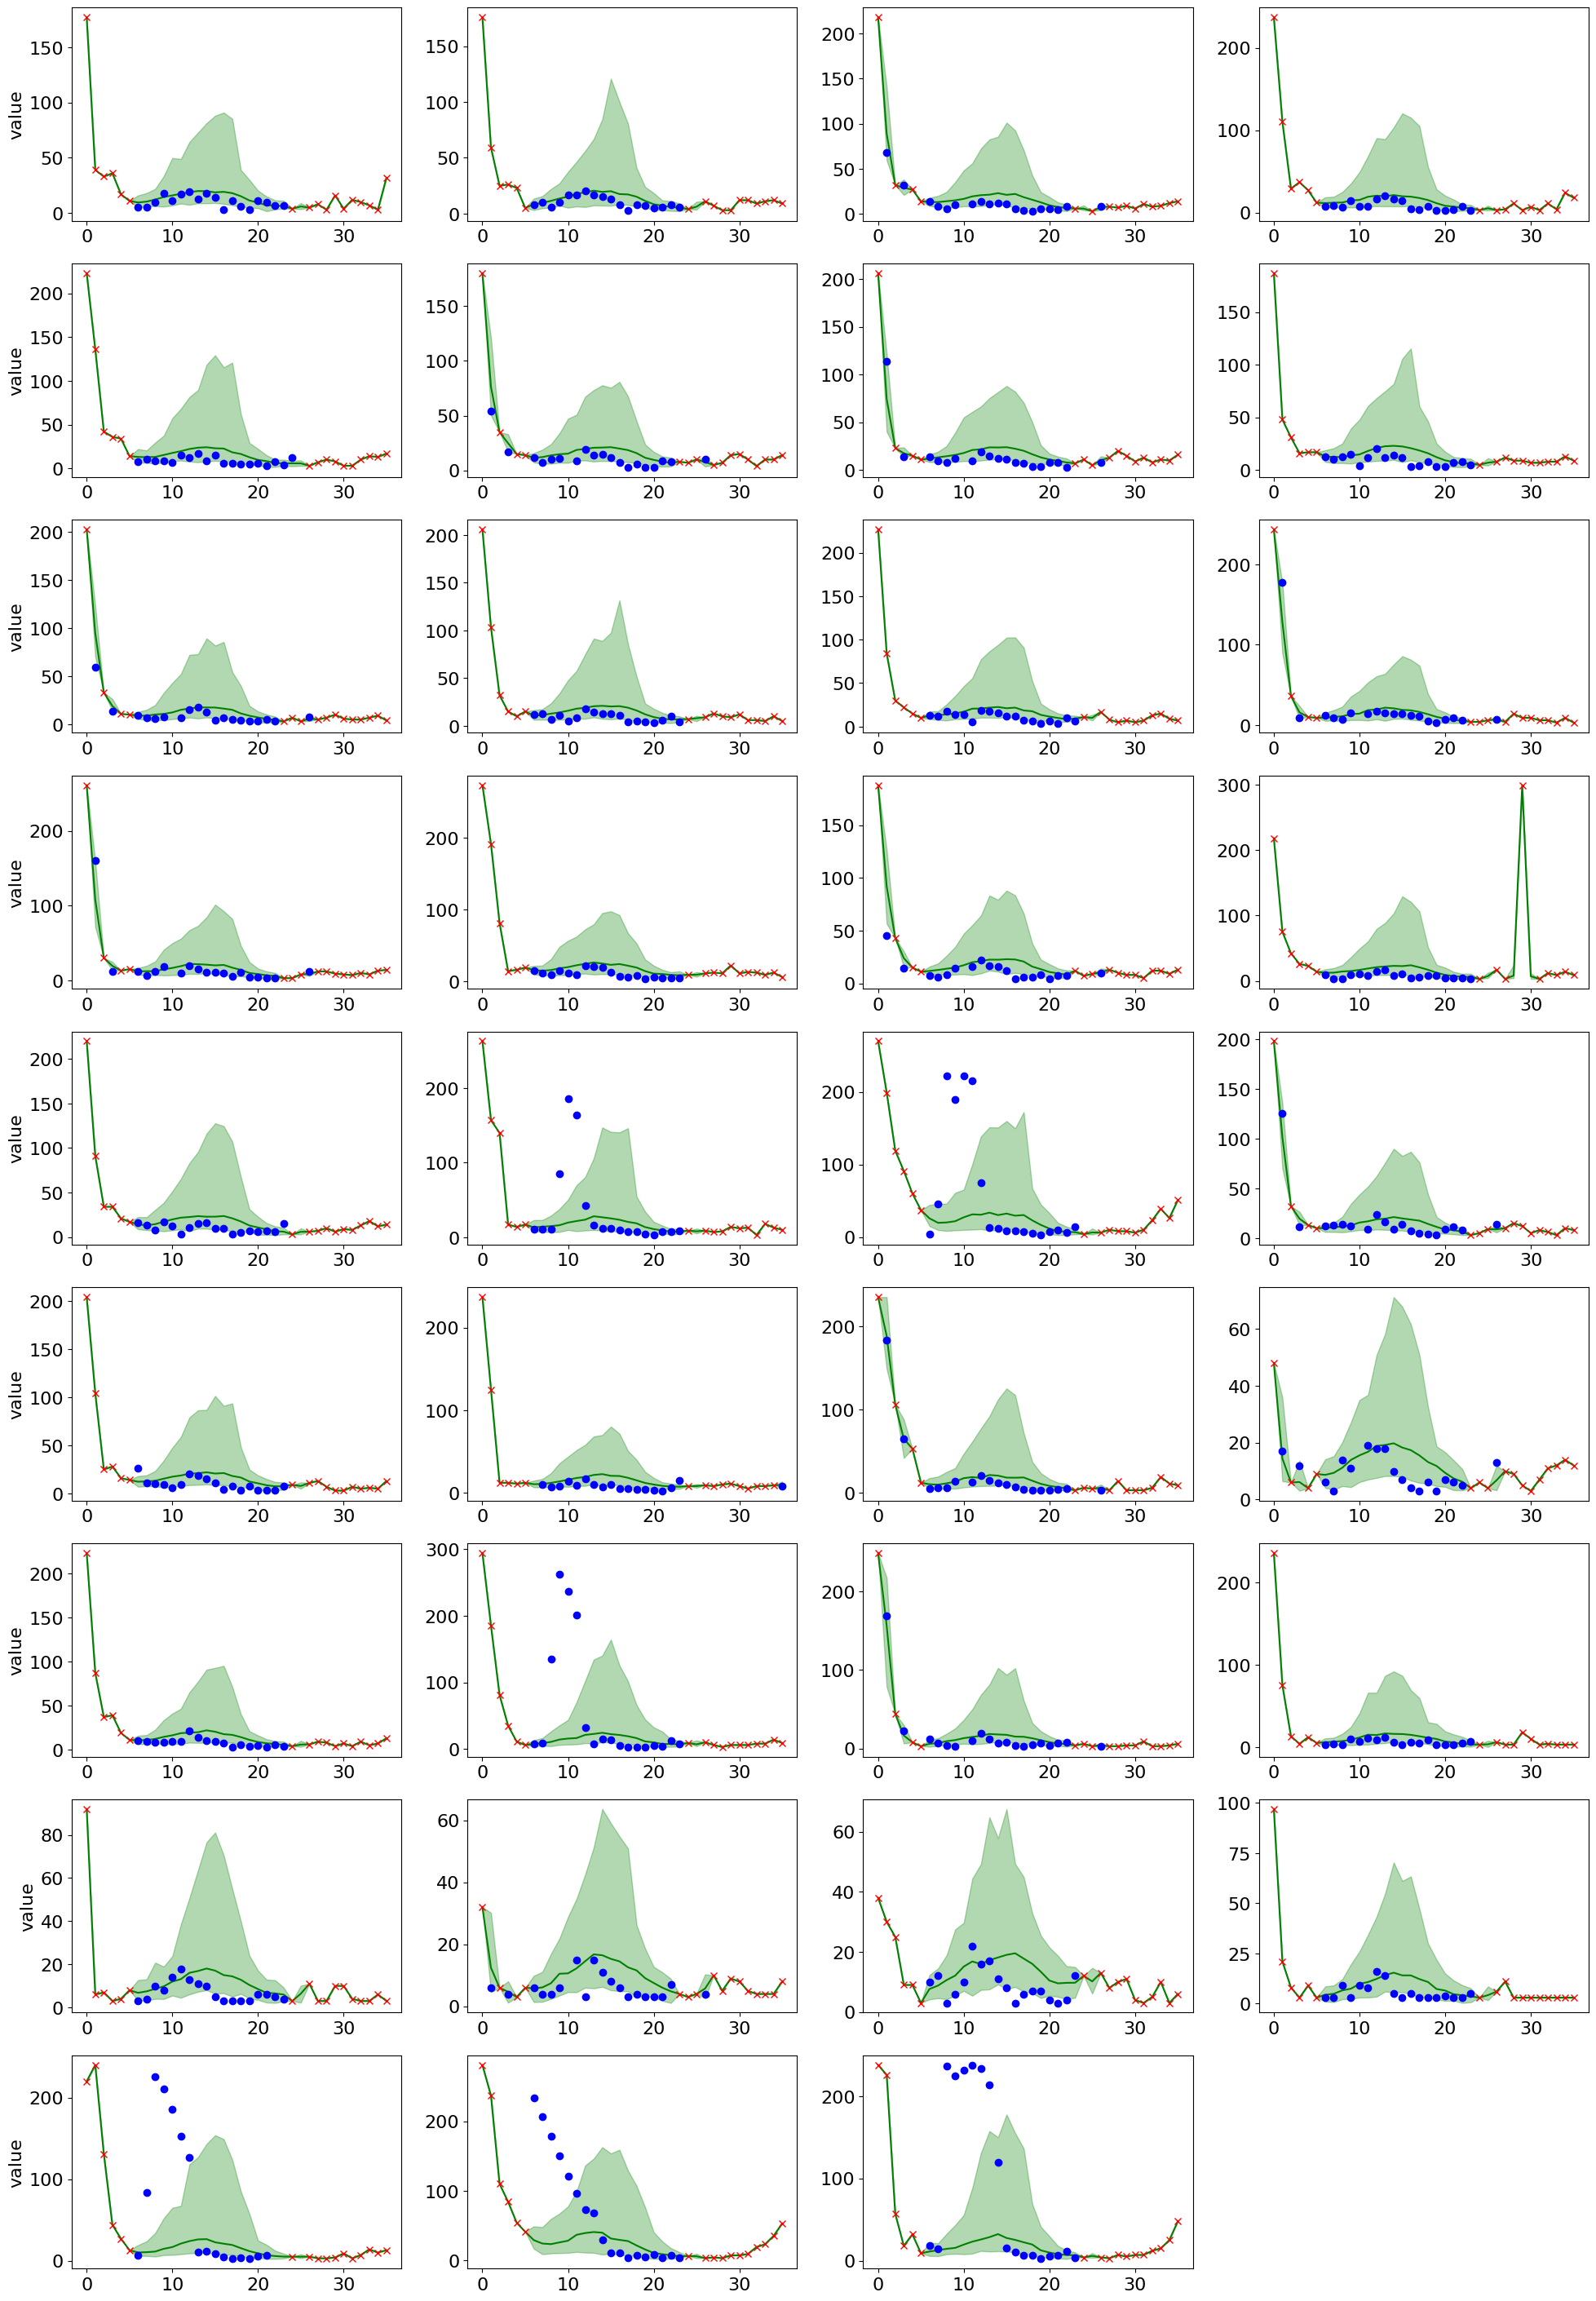

In [24]:
###healthcare###
dataind = 5 #change to visualize a different time-series sample

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k in range(K):
    
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    
    
    row = k // 4
    col = k % 4
    #绿色是估计的取值范围
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k],quantiles_imp[4][dataind,:,k],
                    color='g', alpha=0.3)
    #藍色的点是 真实值
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    #红色点是 条件
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')


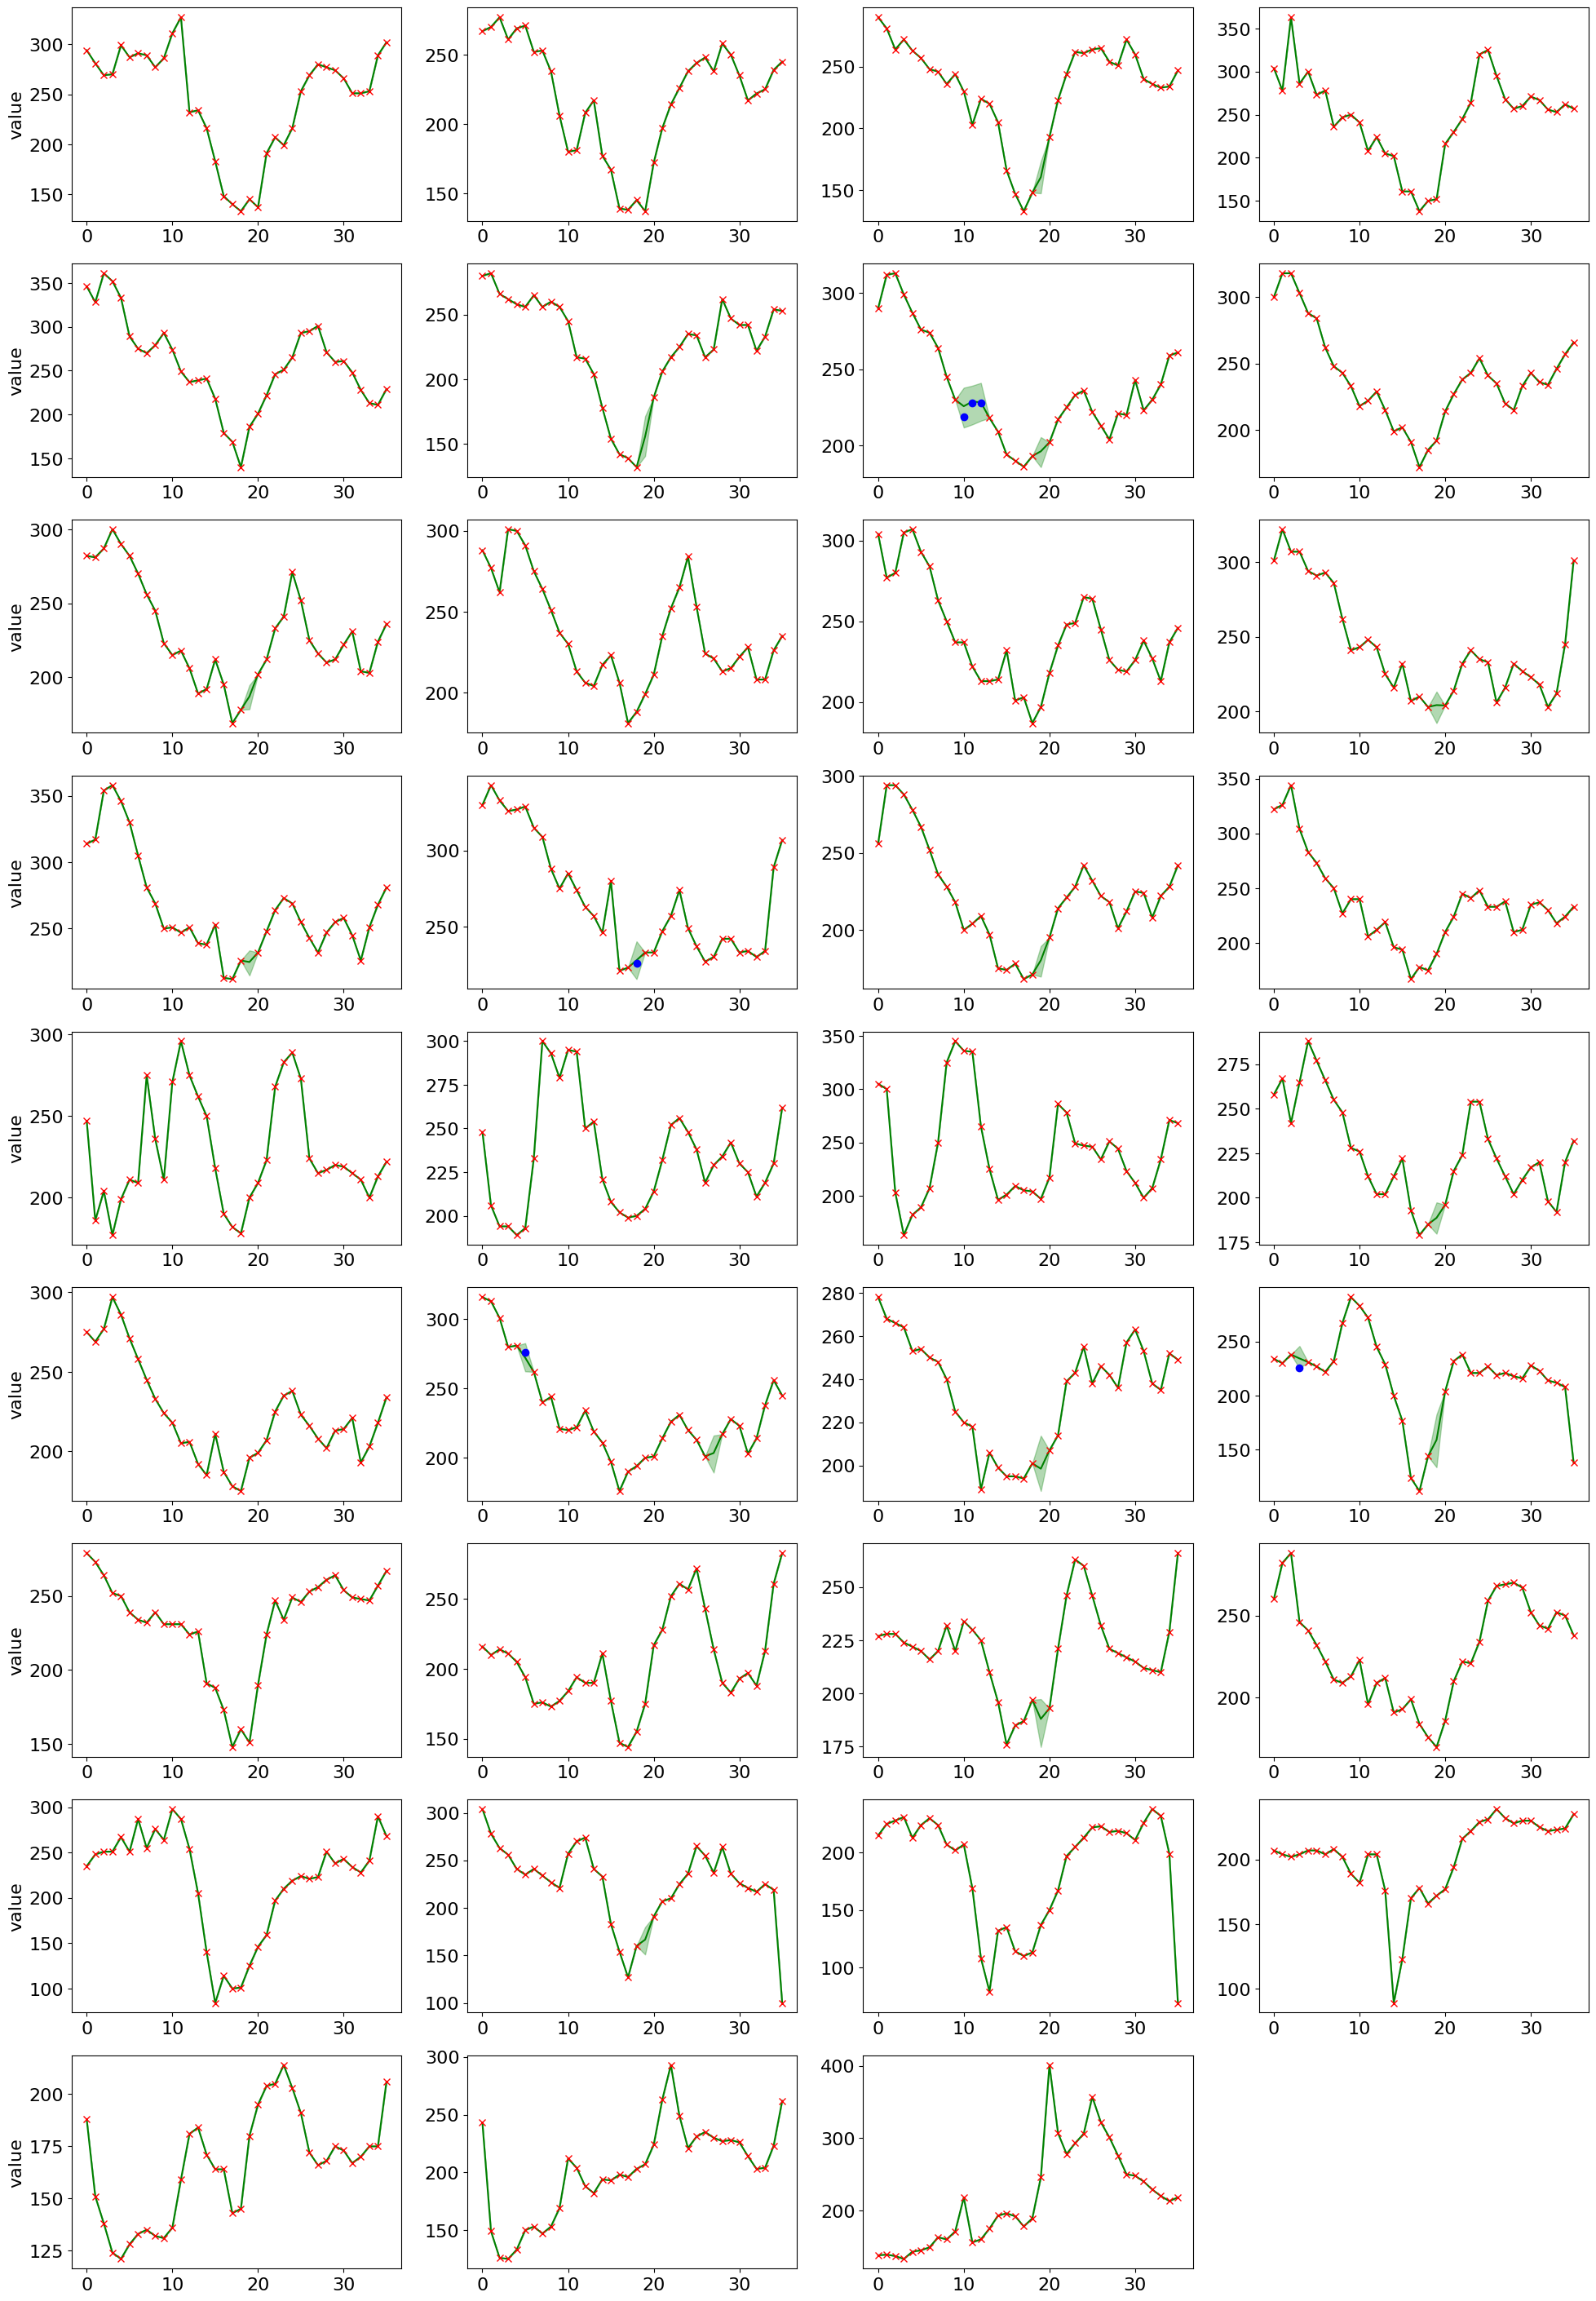

In [22]:
###airquality###
dataind = 4 #change to visualize a different sample

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k in range(K):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k],quantiles_imp[4][dataind,:,k],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')
